In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import statsmodels.api as sm

plt.style.use('ggplot')

In [2]:
# https://population.un.org/wpp/Download/Standard/CSV/
un = pd.read_csv('WPP2019_PopulationByAgeSex_Medium.csv')

un.replace('Bolivia (Plurinational State of)', 'Bolivia', inplace=True)
un.replace('Venezuela (Bolivarian Republic of)', 'Venezuela', inplace=True)
un.replace('Iran (Islamic Republic of)', 'Iran', inplace=True)

In [3]:
# http://ghdx.healthdata.org/gbd-results-tool?params=gbd-api-2019-permalink/31dd9609036871b0e51adfd08e154284
files = []
for file in os.listdir('.'):
    if re.match('IHME-GBD_2019_DATA-711e32d7-\d+.csv', file):
        files.append(file)
gbd = pd.concat(pd.read_csv(file) for file in files)

gbd.replace('Bolivia (Plurinational State of)', 'Bolivia', inplace=True)
gbd.replace('Venezuela (Bolivarian Republic of)', 'Venezuela', inplace=True)
gbd.replace('Iran (Islamic Republic of)', 'Iran', inplace=True)

In [4]:
COUNTRY = 'Malawi'
START = 2000
YEAR = 2021
INTERVENTION = 2025
COUNTERFACTUAL = INTERVENTION + 8

DISCOUNT = 0.04
SOURCE = 0.25

STEP = 5
AGES = np.arange(0, 80 + STEP, STEP)
COLUMNS = [str(AGES[i]) + '-' + str(AGES[i + 1] - 1) for i in range(len(AGES) - 1)]

COLOR = [mpl.cm.cividis(x) for x in np.linspace(1, 0, len(COLUMNS))]
COLOR3 = [mpl.cm.cividis(x) for x in np.linspace(1, 0, 3)]
KARGS = {'color': COLOR, 'legend': False, 'linewidth': 3}
FIGSIZE = (14, 8)

# https://stackoverflow.com/a/30781039
cmap, norm = mpl.colors.from_levels_and_colors(AGES, COLOR)
SM = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
SM.set_array([])

In [5]:
def get_pop(country):
    df = un[un['Location'] == country].pivot_table('PopTotal', 'Time', 'AgeGrp')

    return df[COLUMNS].loc[START:]*1e3 

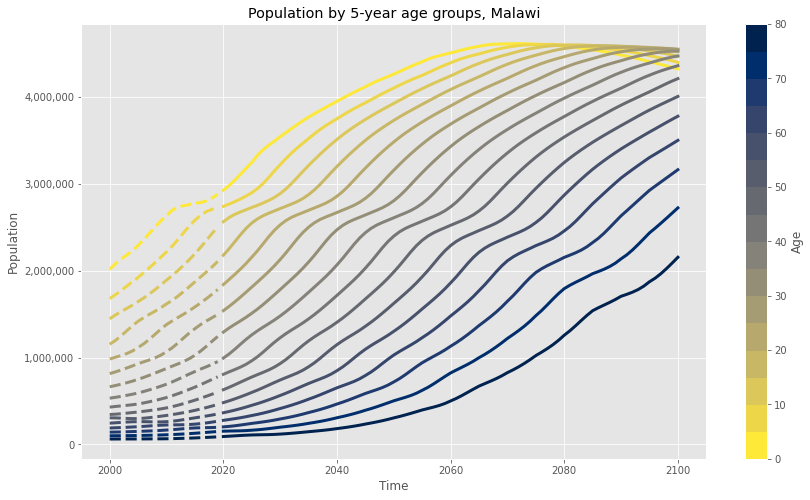

In [6]:
pop = get_pop(COUNTRY)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Population by 5-year age groups, %s' % COUNTRY)
ax.set_ylabel('Population')
_ = pop.loc[:2019].plot(ax=ax, linestyle='--', **KARGS)
_ = pop.loc[2020:].plot(ax=ax, **KARGS)
_ = fig.colorbar(SM, label='Age')

In [7]:
def get_dalys(country):
    df = gbd[gbd['location'] == country].pivot_table('val', 'year', 'age')
    df.columns = [re.sub(' to ', '-', column) for column in df.columns]
    df['0-4'] = df['Under 5']
    df['95-99'] = df['95 plus']

    return df[COLUMNS].loc[START:]

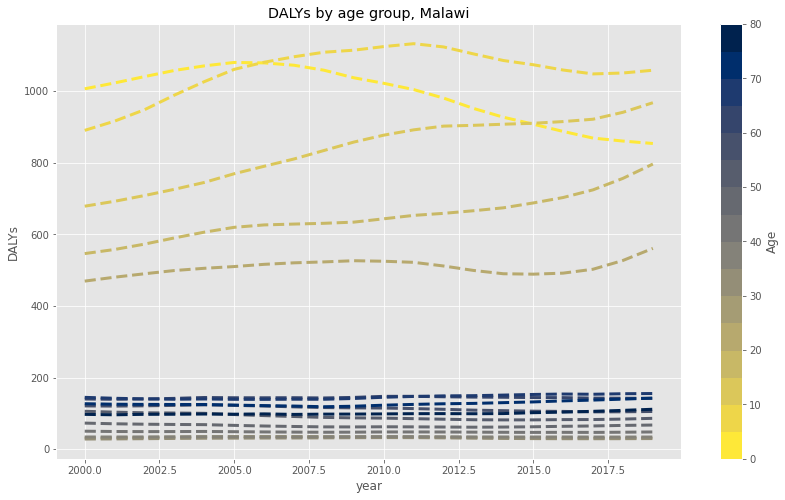

In [8]:
dalys = get_dalys(COUNTRY)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_title('DALYs by age group, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = dalys.plot(ax=ax, linestyle='--', **KARGS)
_ = fig.colorbar(SM, label='Age')

In [9]:
def get_rate(dalys, pop):
    return (dalys/pop).dropna(how='all')*1e5

In [10]:
def get_pred(pop, rate):
    df = pd.DataFrame(index=pop.index[pop.index > rate.index[-1]], columns=COLUMNS)
    for column in COLUMNS:
        X = rate.index
        X = sm.add_constant(X)
        y = np.log(rate[column])
        model = sm.OLS(y, X).fit()

        X_pred = df.index
        X_pred = sm.add_constant(X_pred)
        # Assume that, at most, predicted rate for a given age group remains the same
        df[column] = np.minimum(np.exp(model.predict(X_pred)), np.mean(rate[column]))
    return df

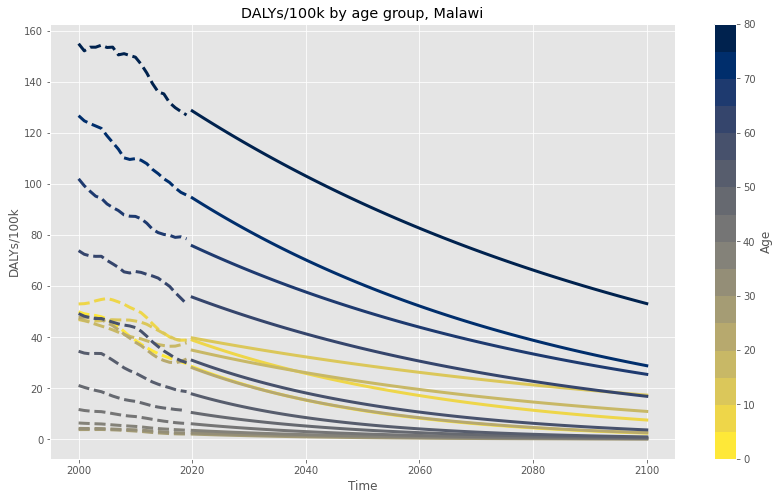

In [11]:
rate = get_rate(dalys, pop)

pred = get_pred(pop, rate)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_ylabel('DALYs/100k')
ax.set_title('DALYs/100k by age group, %s' % COUNTRY)
_ = rate.plot(ax=ax, linestyle='--', **KARGS)
_ = pred.plot(ax=ax, **KARGS)
_ = fig.colorbar(SM, label='Age')

In [12]:
def get_proj(pop, pred):
    return pop.loc[pred.index[0]:]*pred/1e5

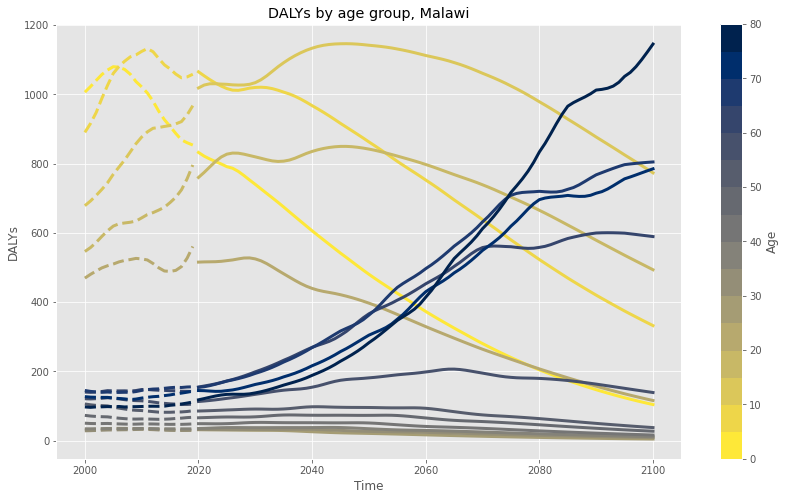

In [13]:
proj = get_proj(pop, pred)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_title('DALYs by age group, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = dalys.plot(ax=ax, linestyle='--', **KARGS)
_ = proj.plot(ax=ax, **KARGS)
_ = fig.colorbar(SM, label='Age')

In [14]:
def get_cohorts(proj):
    df = pd.DataFrame(0.0, index=proj.index[proj.index >= YEAR], columns=proj.index[proj.index >= INTERVENTION])

    for i in range(len(df.columns)):
        birth = df.columns[i]
        for j in range(len(df.index)):
            year = df.index[j]
            k = np.argwhere((year - birth) >= AGES)
            if k.size > 0:
                df.iloc[j, i] = proj[COLUMNS[np.max(k)]].iloc[j]/STEP
    
    return df

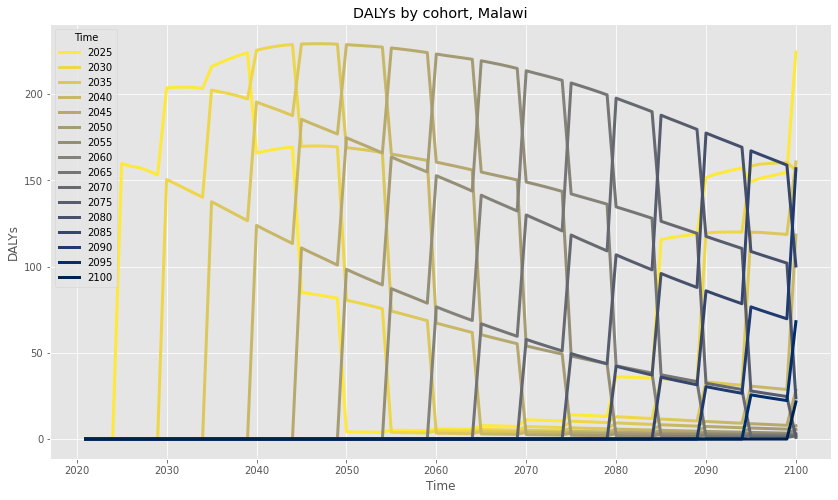

In [15]:
cohorts = get_cohorts(proj)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_title('DALYs by cohort, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = cohorts[INTERVENTION + AGES[:-1]].plot(ax=ax, color=COLOR, linewidth=3)

In [16]:
def get_growth(pop):
    s = np.maximum(pop.sum(axis=1).pct_change(), 0.0)
    return (1 + s).cumprod().fillna(1.0)

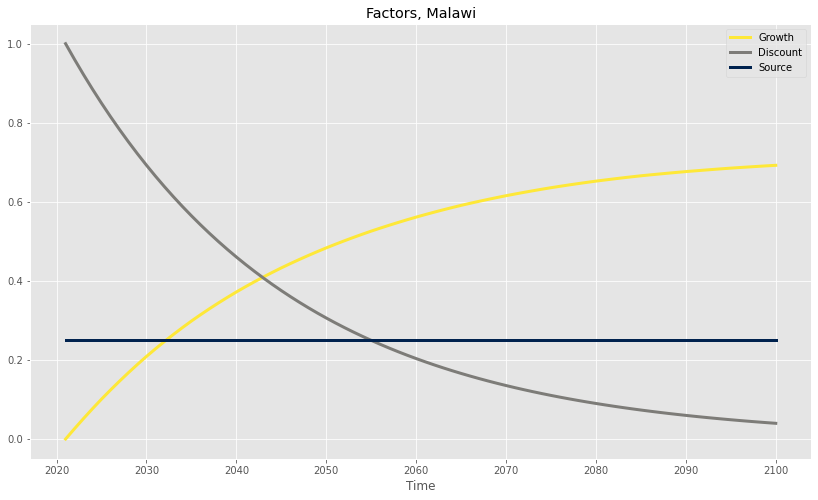

In [17]:
growth = get_growth(pop)

factor = pd.DataFrame(index=cohorts.index, columns=['Growth', 'Discount', 'Source'])
s = growth.copy()
s.loc[YEAR:] = growth.loc[YEAR]
factor['Growth'] = (1 - s.div(growth))
factor['Discount'] = pd.Series(np.power((1 - DISCOUNT), (cohorts.index - YEAR)), index=cohorts.index)
factor['Source'] = SOURCE

fig, ax = plt.subplots(1, 1, figsize=(FIGSIZE))
ax.set_title('Factors, %s' % COUNTRY)
ax.set_ylabel('')
_ = factor.plot(ax=ax, color=COLOR3, linewidth=3)

In [18]:
# Simulate an intervention. Only count projected DALYs of cohorts born after start (interpolating as necessary).
# Only count for fraction of cohort living in new construction (assumed from population growth) without leaded paint.
def sim(year, cohorts, growth):
    df = cohorts[cohorts.columns[cohorts.columns > year]]
    s = growth.copy()
    s.loc[year:] = growth.loc[year]
    return df.multiply(1.0 - s.div(growth), axis=1).dropna(axis=1)

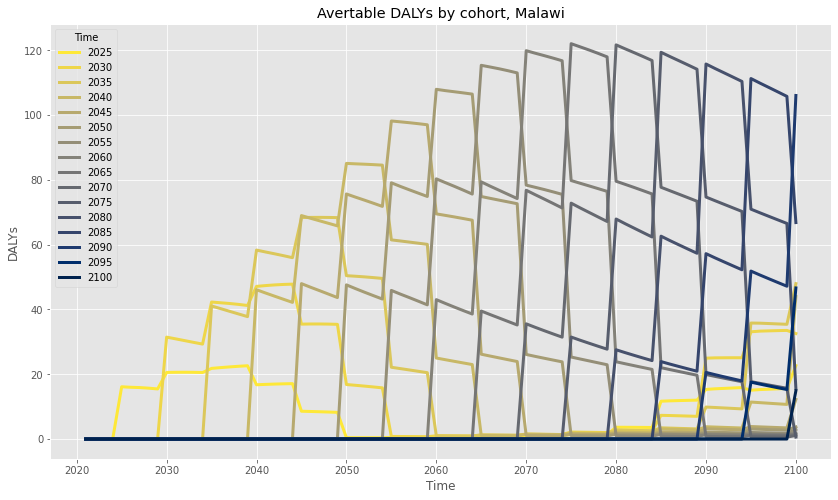

In [19]:
intervention = sim(YEAR, cohorts, growth)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_title('Avertable DALYs by cohort, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = intervention[INTERVENTION + AGES[:-1]].plot(ax=ax, color=COLOR, linewidth=3)

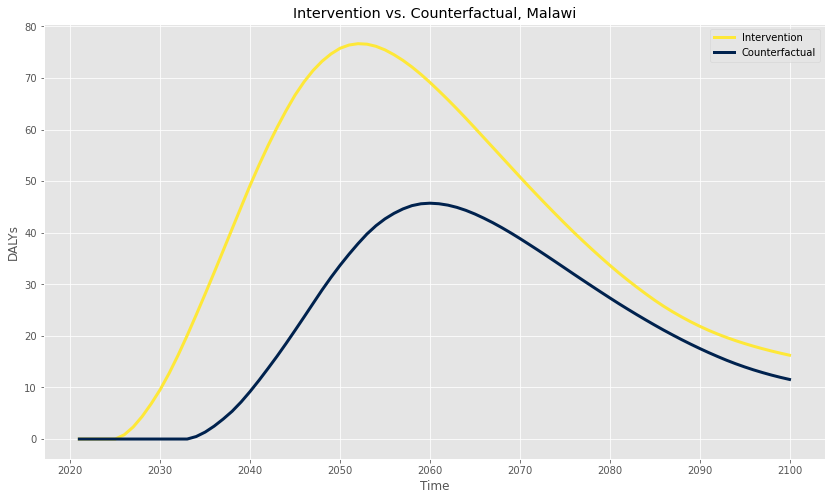

In [20]:
f = factor['Discount']*factor['Source']

results = pd.DataFrame(index=proj.index, columns=['Intervention', 'Counterfactual'])
results['Intervention'] = sim(INTERVENTION, cohorts, growth).sum(axis=1)*f
results['Counterfactual'] = sim(COUNTERFACTUAL, cohorts, growth).sum(axis=1)*f

fig, ax = plt.subplots(1, 1, figsize=(FIGSIZE))
ax.set_title('Intervention vs. Counterfactual, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = results.plot(ax=ax, color=[COLOR3[0], COLOR3[-1]], linewidth=3)

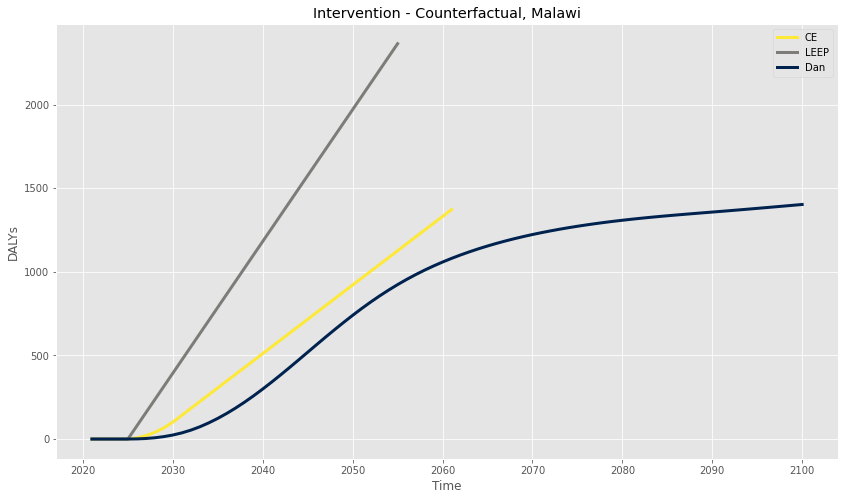

In [21]:
diff = pd.DataFrame(index=proj.index, columns=['CE', 'LEEP', 'Dan'])
diff['CE'] = pd.Series(np.array([0, 0, 0, 0, 0, 7, 13, 20, 27, 34, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41]), index=np.arange(YEAR, YEAR + 41))
diff['LEEP'] = pd.Series(np.hstack([np.zeros(5), np.ones(30)*24300*0.007105/np.power(1.04, 20)]), np.arange(YEAR, YEAR + 35))
diff['Dan'] = results['Intervention'] - results['Counterfactual']

fig, ax = plt.subplots(1, 1, figsize=(FIGSIZE))
ax.set_title('Intervention - Counterfactual, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = diff.cumsum().plot(ax=ax, color=COLOR3, linewidth=3)

In [22]:
countries = set(un['Location'].unique()) & set(gbd['location'].unique())
diff = pd.DataFrame(index=proj.index, columns=countries)
for country in countries:
    pop = get_pop(country)
    dalys = get_dalys(country)
    rate = get_rate(dalys, pop)
    pred = get_pred(pop, rate)
    proj = get_proj(pop, pred)
    cohorts = get_cohorts(proj)
    growth = get_growth(pop)
    intervention = sim(INTERVENTION, cohorts, growth).sum(axis=1)*f
    counterfactual = sim(COUNTERFACTUAL, cohorts, growth).sum(axis=1)*f
    diff[country] = (intervention - counterfactual).cumsum()

print(diff.iloc[-1].sort_values(ascending=False).to_string())

India                               53060.144556
Pakistan                            20446.066534
Somalia                             10457.328833
Democratic Republic of the Congo     9117.518664
Afghanistan                          8025.365997
Niger                                7422.582452
Egypt                                6522.146160
Yemen                                5430.867776
Nigeria                              5374.382312
Sudan                                4870.727725
Mali                                 2991.792356
Burkina Faso                         2457.567686
Mozambique                           2282.624730
Burundi                              2166.277636
Madagascar                           1966.806921
Cameroon                             1891.170858
United Republic of Tanzania          1855.896899
Iraq                                 1631.942658
Malawi                               1402.445260
Ethiopia                             1378.473013
Guinea              